Here we will try to do some creation of a vector field from the brushstrokes generated in the last image.

Firstly we want to expand each brushstroke so that they fill the frame. We can do this with a morphological transform. We will follow a fairly basic process:
1. Fill a frame with ones, call this A
2. Iterate over each brushstroke, growing it slightly
3. Elementwise multiply it by the matrix A.
4. Subtract this from A. Over time A will represent the area which is not assigned to a brushtroke.

In [73]:
import cv2
import scipy.stats.qmc as qmc
import scipy
import matplotlib.pyplot as plt 
import numpy as np
import pickle
from collections import Counter
import random

In [74]:
with open('../out/m.pkl', 'rb') as inp:
    gradients = pickle.load(inp)
with open('../out/strokes.pkl', 'rb') as inp:
    brushstrokes = pickle.load(inp)
sz = np.shape(brushstrokes[0])
numbrush = len(brushstrokes)
thetas = np.arctan(gradients)
im = cv2.imread('../res/starry_night_crop.jpg')
im = cv2.colorChange(im, None, cv2.COLOR_RGB2BGR)

In [75]:
kernel = np.ones([3,3], np.uint8)
brushstrokes_dilated = brushstrokes.copy()
indices = list(range(numbrush))
A = np.ones(sz, np.uint8)
#First pass - remove current brushstrokes from A
for i in range(numbrush):
    A = A-brushstrokes[i]

while len(indices) > 0:
    for i in range(len(indices)-1,-1,-1):
        
        idx = indices[i]
        dilated = cv2.dilate(np.uint8(brushstrokes_dilated[idx]), kernel)
        check_idx = 65
        # if (idx==check_idx):

            # plt.subplot(1,4,1)
            # plt.imshow(dilated)
        dilated = dilated * A + brushstrokes_dilated[idx]
        # if (idx==check_idx):
            # plt.subplot(1,4,2)
            # plt.imshow(dilated)
        if (np.sum(dilated) == np.sum(brushstrokes_dilated[idx])):
            indices.pop(i)
            break
        else:
            brushstrokes_dilated[idx] = dilated
            A = A - dilated*A
        # if (idx==check_idx):
            # print("C",np.sum(brushstrokes[idx]),",", np.sum(brushstrokes_dilated[idx]))
            # plt.subplot(1,4,3)
            # plt.imshow(brushstrokes_dilated[idx])
            # plt.subplot(1,4,4)
            # plt.imshow(A)
            # plt.show()


Next we want to identify every brushstroke's three nearest neighbours. We can do this by dilating each brushstroke by one pixel, multiplying a matrix containing each brushstroke's index by this dilated pixel, and identifying each item in that appears in that matrix.

In [76]:
k = 5

matrix_of_indices = np.zeros(sz)
kernel = np.ones([2,2])
neighbours = np.zeros([numbrush, k], np.int64) - 1
# neighbour_1 = np.zeros(numbrush)-1
# neighbour_2 = np.zeros(numbrush)-1
# neighbour_3 = np.zeros(numbrush)-1
for i in range(numbrush):
    matrix_of_indices = matrix_of_indices + i * brushstrokes_dilated[i]
for i in range(numbrush):
    dilation = cv2.dilate(brushstrokes_dilated[i], kernel)-brushstrokes_dilated[i]
    selection_matrix = np.bool8(dilation)
    selected = matrix_of_indices[selection_matrix]
    counter = Counter(selected)
    k_items = counter.most_common(k)
    for j in range(len(k_items)):
        neighbours[i,j] = k_items[j][0]
    # if (len(k_items) > 0):
    #     neighbour_1[i] = k_items[0][0]
    # if (len(k_items) > 1):
    #     neighbour_2[i] = k_items[1][0]
    # if (len(k_items) > 2):
    #     neighbour_3[i] = k_items[2][0]

vector_of_xmeans = np.zeros([1,numbrush])
vector_of_ymeans = np.zeros([1,numbrush])
a = np.ones([sz[0],1])
b = np.array([range(sz[1])])
x_ordinates = np.reshape(a @ b, sz[0]*sz[1])

a = np.array([range(sz[1])]).T
b = np.ones([sz[0],1]).T
y_ordinates =  np.reshape(a @ b, sz[0]*sz[1])
for i in range(numbrush):
    x_ords_brush = np.reshape(np.bool8(brushstrokes[i]), sz[0]*sz[1])
    x_ords_brush = x_ordinates[x_ords_brush]
    x_mean = np.mean(x_ords_brush)
    vector_of_xmeans[0,i] = x_mean

    y_ords_brush = np.reshape(np.bool8(brushstrokes[i]), sz[0]*sz[1])
    y_ords_brush = y_ordinates[y_ords_brush]
    y_mean = np.mean(y_ords_brush)
    vector_of_ymeans[0,i] = y_mean
matrix_of_xmeans = np.ones([numbrush,1]) @ vector_of_xmeans
matrix_of_ymeans = np.ones([numbrush,1]) @ vector_of_ymeans

matrix_of_xdist = matrix_of_xmeans - matrix_of_xmeans.T
matrix_of_ydist = matrix_of_ymeans - matrix_of_ymeans.T
matrix_of_dist_sq = matrix_of_xdist * matrix_of_xdist + matrix_of_ydist * matrix_of_ydist
matrix_of_dist = np.sqrt(matrix_of_dist_sq)


In [77]:
def get_polarity_probability(region_index, polarities):
    probability = 0
    # indxes = np.array([neighbour_1[region_index], neighbour_2[region_index], neighbour_3[region_index]], np.int64)
    # indxes = neighbours[region_index,:]
    indxes = np.argsort(matrix_of_dist[region_index])[1:k+1]
    for idx in indxes:
        if ((idx != -1) and (polarities[idx] != 0)):
            dtheta = (thetas[region_index]-thetas[idx]+np.pi/2)%np.pi-np.pi/2
            p = np.cos(dtheta)
            sign_applied = 1
            mean_theta_abs = (abs(thetas[region_index])+abs(thetas[idx]))/2
            if mean_theta_abs < np.pi / 4:
                sign_applied = np.sign(thetas[region_index]) * np.sign(thetas[idx])
            if (np.abs(probability) ==0):
                probability = p * polarities[idx]*sign_applied
    return probability

def get_probability_vector(polarities):
    theta_mat = np.ones([numbrush,1])@np.array([thetas])
    dtheta_mat = (theta_mat-theta_mat.T+np.pi/2)%np.pi-np.pi/2
    angle_factor = np.cos(dtheta_mat)
    mean_theta_abs = (np.abs(theta_mat)+np.abs(theta_mat.T))/2
    mask_sign = np.bool8(mean_theta_abs < np.pi/4)
    sign_matrix = np.zeros([numbrush,numbrush])
    sign_matrix[mask_sign] = (np.sign(theta_mat)*np.sign(theta_mat.T))[mask_sign]
    sign_matrix[np.bool8(1-mask_sign)] = 1
    polarities_factor = np.ones([numbrush,1])@np.array([polarities])
    matrix_of_dist_sq_zero_diag = matrix_of_dist
    matrix_of_dist_sq_zero_diag[np.bool8(np.eye(numbrush, numbrush))] = np.inf
    probability_matrix = angle_factor * sign_matrix / matrix_of_dist_sq_zero_diag *polarities_factor
    probability_vector = np.sum(probability_matrix, axis = 1)
    mask_already_assigned = np.bool8(polarities!=0)
    probability_vector[mask_already_assigned] = 0
    return (probability_vector)

        

In [78]:
#SANITY CHECKER
# numbrush = 3
# thetas = np.array([-np.pi/2+0.1,0.1,0.1])
# matrix_of_dist_sq = np.array([[0,0.5,0.5],[0.5,0,0.5],[0.5,0.5,0]])
# polarities = np.array([0,1,0])
# get_probability_vector(polarities)

In [79]:

random.seed(1)
def get_polarity_option():
    polarities = np.zeros([numbrush])
    valid = True
    #1: randomly assign one polarity
    ran_brush = random.randint(0,numbrush-1)
    polarities[ran_brush] = 1
    while 0 in polarities:
        probabilities = get_probability_vector(polarities)
        
        index_to_change = np.argmax(np.abs(probabilities))
        polarities[index_to_change] = np.sign(probabilities[index_to_change])
    # while 0 in polarities:
        ###THE NEXT SECTION WORKS
        # probabilities = np.zeros([numbrush])
        # for i in range(numbrush):
        #     if (polarities[i] == 0):
        #         probabilities[i] = get_polarity_probability(i, polarities)
        # if np.max(np.abs(probabilities)) == 0:
        #     valid = False
        #     break
        # index_to_change = np.argmax(np.abs(probabilities))
        # polarities[index_to_change] = np.sign(probabilities[index_to_change])
        #####
        # brush_directions = np.zeros(sz)+0.5
        # for k in range(numbrush):
        #     brush_directions += brushstrokes[k]*(polarities[k])/2
        # plt.imshow(brush_directions)
        # plt.title(str(ctr))
        # plt.show()
        #####
        
    return (valid, polarities)


In [80]:
polarity_option = get_polarity_option()[1]

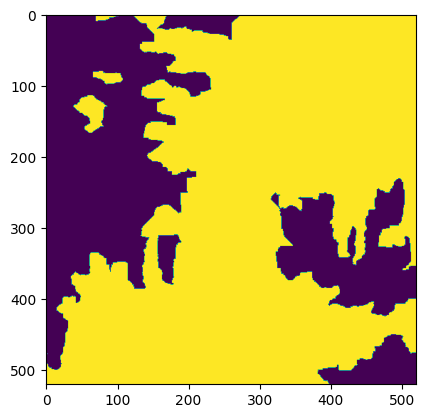

In [81]:
brush_directions = np.zeros(sz)+0.5
for i in range(numbrush):
    brush_directions += brushstrokes_dilated[i]*(polarity_option[i])/2
plt.imshow(brush_directions)

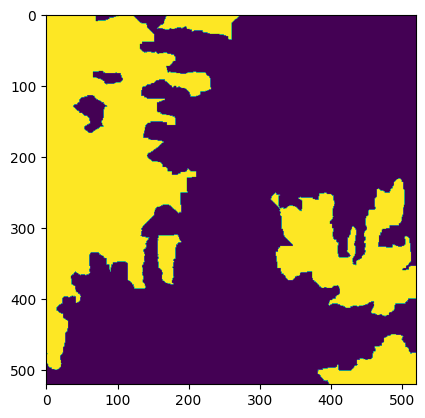

In [82]:
##HYPERPARAMETER
num_polarity_options = 10

opts = np.zeros([num_polarity_options, numbrush])
for i in range(10):
    opt_valid = False
    while opt_valid == False:
        opt = get_polarity_option()
        opt_valid = opt[0]
        opt = opt[1]
    if (i!=0):
        running_best = np.mean(opts, axis=0)
        diff_pos = running_best - opt
        diff_neg = running_best + opt
        if (np.abs(np.sum(diff_neg)) < np.abs(np.sum(diff_pos))):
            opt *= -1
    opts[i,:] = opt

    
brush_directions = np.zeros(sz)
best_polarity = np.sign(np.mean(opts, axis = 0))
for i in range(numbrush):
    brush_directions += brushstrokes_dilated[i]*(best_polarity[i])/2
plt.imshow(brush_directions)

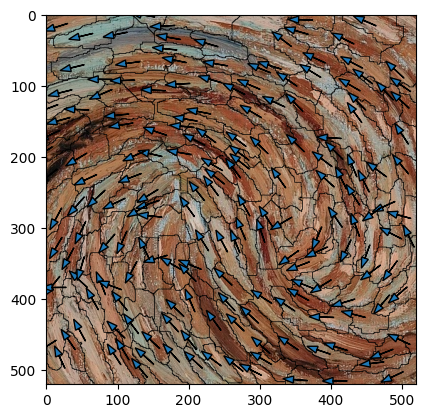

In [89]:
brush_directions = np.zeros(sz)
best_polarity = np.sign(np.mean(opts, axis = 0))
# plt.subplot(1,2,1)
# plt.imshow(im)
im_show = im
border_mask = np.ones(sz)

for i in range(numbrush):
    brush_directions += cv2.erode(brushstrokes_dilated[i], np.ones([2,2]))
    sf = 20
    magnitude = np.sqrt(1+1/gradients[i]/gradients[i])
    border_mask -= cv2.erode(brushstrokes_dilated[i],np.array([[1,1],[1,1]]))
    plt.arrow(vector_of_xmeans[0,i], vector_of_ymeans[0,i], sf/magnitude/gradients[i]*best_polarity[i], sf/magnitude*best_polarity[i], head_width = 10)
im_show[np.bool8(border_mask),:] = 0
plt.imshow(im_show)
# plt.imshow(brush_directions)

# plt.imshow(brush_directions)
# plt.subplot(1,2,2)


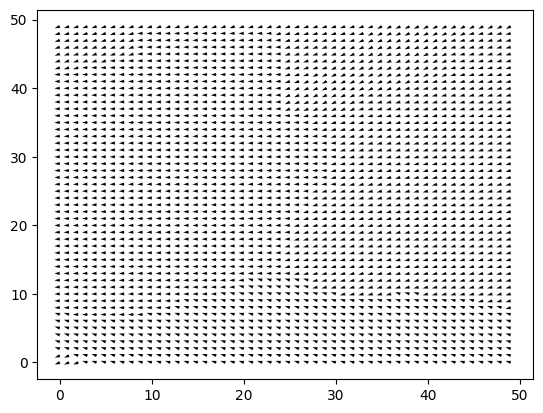

In [84]:
U = np.zeros(sz)
V = np.zeros(sz)

for i in range(numbrush):
    V += brushstrokes_dilated[i]*best_polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])
    U += brushstrokes_dilated[i]*best_polarity[i]/np.sqrt(1+1/gradients[i]/gradients[i])/gradients[i]
start = 400
end = 450
plt.quiver(U[start:end,start:end],V[start:end,start:end])

# Promising?

(520, 520)


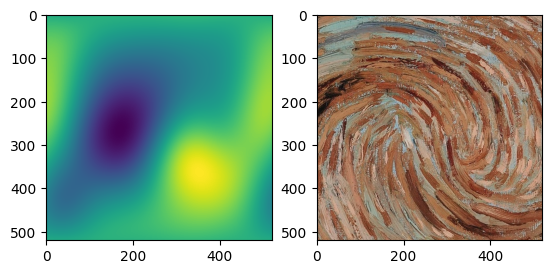

In [85]:
aspect_ratio = sz[1]/sz[0]
coordinates_x = np.ones([sz[0],1]) @ np.array([range(sz[1])])*aspect_ratio/sz[1]
coordinates_y = (np.array([range(sz[0])])/sz[0]).T * np.ones([1,sz[1]])

wavenumbers_1d_x = np.int64(np.array([np.fft.fftfreq(sz[1]) * sz[1]]))
n_fft_points_x = wavenumbers_1d_x.shape[1]
wavenumbers_1d_y = np.int64(np.array([np.fft.fftfreq(sz[0]) * sz[0]]))
n_fft_points_y = wavenumbers_1d_y.shape[1]
wavenumbers_x = np.ones([n_fft_points_y,1]) @ wavenumbers_1d_x
wavenumbers_y = wavenumbers_1d_y.T @ np.ones([1,n_fft_points_x])
w_x_w_y = wavenumbers_x*wavenumbers_x+wavenumbers_y*wavenumbers_y
k = 0.3
flter = np.exp(-k*w_x_w_y)
d_u_d_y_fft = 1j * wavenumbers_y * np.fft.fft2(U)
d_v_d_x_fft = 1j * wavenumbers_x * np.fft.fft2(V)
curl_fft = d_v_d_x_fft - d_u_d_y_fft
curl_fft *= flter

print(curl_fft.shape)
curl = np.fft.ifft2(curl_fft, sz)
curl = np.real(curl)
plt.subplot(1,2,1)
plt.imshow(curl)
plt.subplot(1,2,2)
plt.imshow(im)

